# Serial simulation

In [1]:
import logging
import sys

root = logging.getLogger()
root.setLevel(logging.DEBUG)
# create console handler
ch = logging.StreamHandler(sys.stdout)
ch.setLevel(logging.WARNING)
# create formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
# add formatter to console handler
ch.setFormatter(formatter)
# add console handler to root logger
root.addHandler(ch)

In [2]:
import numpy as np
from decimal import Decimal

In [3]:
from latticemc.definitions import Lattice, LatticeState, OrderParametersHistory, DefiningParameters
from latticemc.lattice_tools import initialize_partially_ordered
from latticemc.random_quaternion import random_quaternion
from latticemc.updaters import Updater, OrderParametersCalculator, FluctuationsCalculator, DerivativeWiggleRateAdjustor, RandomWiggleRateAdjustor, CallbackUpdater, AcceptanceRateWiggleRateAdjustor
from latticemc.failsafe import failsafe_save_simulation
from latticemc.parallel import SimulationRunner
from latticemc import simulation_numba

In [4]:
lattice = Lattice(9, 9, 9)
initialize_partially_ordered(lattice, x=random_quaternion(1))

model_params = DefiningParameters(temperature=Decimal(0.9), lam=Decimal(0.3), tau=Decimal(1))
state = LatticeState(parameters=model_params, lattice=lattice)
order_parameters_history = {model_params: OrderParametersHistory()}

In [5]:
%matplotlib widget
from matplotlib import pyplot as plt
from IPython import display
import numpy as np

# Set this to True only if you want the legacy inline progress plot (disabled by default)
USE_PROGRESS_INLINE = False

_progress_fig = None
_progress_axes = None

def plot_progress(state: LatticeState, max_window: float, step: int):
    if not USE_PROGRESS_INLINE:
        return  # Prevents creation of inline figures
    global _progress_fig, _progress_axes
    op = order_parameters_history[state.parameters].order_parameters
    if _progress_fig is None or _progress_axes is None:
        _progress_fig, _progress_axes = plt.subplots(3)
        _progress_fig.set_size_inches(10, 10)
        for ax in _progress_axes:
            ax.grid(True)
    ax = _progress_axes
    for a in ax:
        a.clear(); a.grid(True)
    start = step if op.size < max_window else (op.size - max_window)
    size = op.size if op.size < max_window else max_window
    x = np.linspace(start, start + size, size // step - 1) if size // step - 1 > 0 else []
    if len(x):
        ax[0].plot(x, op['energy'][start::step], label='energy')
        ax[1].plot(x, op['p'][start::step], label='p')
        ax[1].plot(x, op['q0'][start::step], label='q0')
        ax[1].plot(x, op['q2'][start::step], label='q2')
        ax[1].plot(x, op['d322'][start::step], label='d322')
        ax[2].plot(x, op['w'][start::step], label='w')
    ax[0].legend(); ax[1].legend(); ax[2].legend()
    display.display(_progress_fig)
    display.clear_output(wait=True)

In [6]:
order_parameters_calculator = OrderParametersCalculator(order_parameters_history[model_params], how_often=1, since_when=1)#, printEvery=50)
fluctuations_calculator = FluctuationsCalculator(order_parameters_history[model_params], window=100, how_often=50, since_when=100)#, printEvery=50)
updaters = [
    order_parameters_calculator,
    fluctuations_calculator,
    AcceptanceRateWiggleRateAdjustor(how_often=100, since_when=10),
    # DerivativeWiggleRateAdjustor(order_parameters_history=order_parameters_history[model_params], how_many=100, how_often=10, since_when=101),
    RandomWiggleRateAdjustor(scale=0.001, how_often=10, since_when=1),
    RandomWiggleRateAdjustor(scale=1.0, reset_value=1.0, how_often=1000, since_when=1000),
]
# Only add the legacy inline plotting callback if explicitly enabled
if 'USE_PROGRESS_INLINE' in globals() and USE_PROGRESS_INLINE:
    from latticemc.updaters import CallbackUpdater  # safe local import
    updaters.insert(2, CallbackUpdater(lambda state: plot_progress(state, step=10, max_window=10000), how_often=100, since_when=10))

In [ ]:
for it in range(100):
    simulation_numba.do_lattice_state_update(state)

    for u in updaters:
        u.perform(state)

# Parallel simulations

**WARNING**: The simulation will create as many subprocesses as there are temperatures. This will use a lot of memory. Expect crashes!

These settings should run fine on an 8-core processor with 16GB of RAM.

In [7]:
temperatures = np.arange(0.4, 1.7, 0.05)
states = [LatticeState(parameters=DefiningParameters(temperature=round(Decimal(t), 2), lam=Decimal(0.3), tau=1),
                       lattice=Lattice(10, 10, 10))
          for t in temperatures]
for state in states:
    initialize_partially_ordered(state.lattice, x=random_quaternion(1.0))

order_parameters_history = {state.parameters: OrderParametersHistory() for state in states}

In [8]:
per_state_updaters = [
    #DerivativeWiggleRateAdjustor(howMany=100, how_often=10, since_when=100),
    AcceptanceRateWiggleRateAdjustor(how_often=100, since_when=10),
    RandomWiggleRateAdjustor(scale=0.001, how_often=10, since_when=10),
    RandomWiggleRateAdjustor(scale=1.0, reset_value=1.0, how_often=1000, since_when=1000)
]

runner = SimulationRunner(states,
                          order_parameters_history,
                          cycles=10000,
                          report_order_parameters_every=10,
                          report_state_every=1000,
                          per_state_updaters=per_state_updaters,
                          parallel_tempering_interval=10)
runner.start()

In [ ]:
temperatures

Started live updates (interval=2.0s).


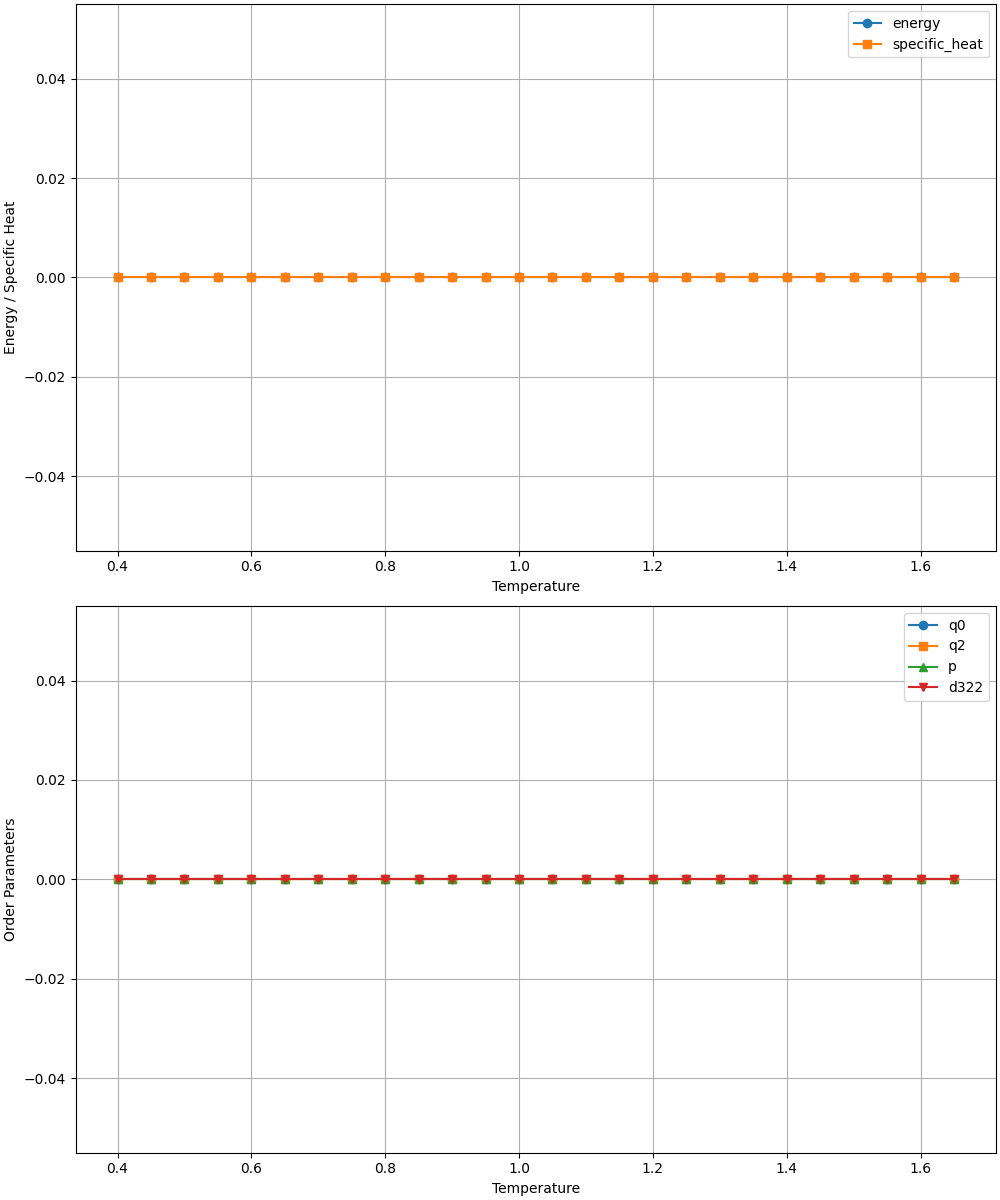

In [9]:
%matplotlib widget
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import display
import time
import threading
import numpy as np

class Plotter:
    """Widget-friendly live plot of thermodynamic and order parameters.
    Uses a single persistent figure (no clear_output) and redraws via canvas.draw_idle()."""
    def __init__(self, temperatures, order_parameters_history, window=1000):
        self.order_parameters_history = order_parameters_history
        self.x = [float(t) for t in temperatures]
        n = len(self.x)
        self.energy = [0]*n
        self.specific_heat = [0]*n
        self.q0 = [0]*n
        self.q2 = [0]*n
        self.par = [0]*n
        self.d322 = [0]*n
        self.w = [0]*n
        self.window = window
        self.fig = None
        self.ax = None
        self.lines = []
        self._updating = False
        self.update_thread = None
        self._build_figure()

    def _build_figure(self):
        if self.fig is not None:
            plt.close(self.fig)
        # Create widget figure - it will automatically display as a widget
        self.fig, self.ax = plt.subplots(2, figsize=(10, 12), constrained_layout=True)
        (l1,) = self.ax[0].plot(self.x, self.energy, marker='o', label='energy')
        (l2,) = self.ax[0].plot(self.x, self.specific_heat, marker='s', label='specific_heat')
        (l3,) = self.ax[1].plot(self.x, self.q0, marker='o', label='q0')
        (l4,) = self.ax[1].plot(self.x, self.q2, marker='s', label='q2')
        (l5,) = self.ax[1].plot(self.x, self.par, marker='^', label='p')
        (l6,) = self.ax[1].plot(self.x, self.d322, marker='v', label='d322')
        self.lines = [l1, l2, l3, l4, l5, l6]
        self.ax[0].set_xlabel('Temperature')
        self.ax[0].set_ylabel('Energy / Specific Heat')
        self.ax[1].set_xlabel('Temperature')
        self.ax[1].set_ylabel('Order Parameters')
        for a in self.ax:
            a.grid(True)
            a.legend()
        # Widget backend automatically displays the figure - no need for display()

    def _safe_draw(self):
        try:
            if self.fig and self.fig.canvas:
                self.fig.canvas.draw_idle()
        except Exception as e:
            print(f"Warning: draw failed: {e}")

    def plot_update(self):
        try:
            for p, oph in self.order_parameters_history.items():
                op = oph.order_parameters
                fl = oph.fluctuations
                t_index = np.nonzero(np.isclose(self.x, float(p.temperature)))[0][0]
                size = min(op.size, self.window) if op.size else 0
                fl_size = min(fl.size, self.window) if fl.size else 0
                if size:
                    sl = op['energy'][-size::10]
                    self.energy[t_index] = float(sl.mean()) if sl.size else 0
                    sl = op['q0'][-size::10]
                    self.q0[t_index] = float(sl.mean()) if sl.size else 0
                    sl = op['q2'][-size::10]
                    self.q2[t_index] = float(sl.mean()) if sl.size else 0
                    sl = np.abs(op['p'][-size::10])
                    self.par[t_index] = float(sl.mean()) if sl.size else 0
                    sl = op['d322'][-size::10]
                    self.d322[t_index] = float(sl.mean()) if sl.size else 0
                else:
                    self.energy[t_index] = 0
                    self.q0[t_index] = 0
                    self.q2[t_index] = 0
                    self.par[t_index] = 0
                    self.d322[t_index] = 0
                if fl_size:
                    slf = fl['energy'][-fl_size::10]
                    self.specific_heat[t_index] = float(slf.mean()) if slf.size else 0
                else:
                    self.specific_heat[t_index] = 0
            # Update line y-data
            for arr, line in zip(
                [self.energy, self.specific_heat, self.q0, self.q2, self.par, self.d322],
                self.lines,
            ):
                line.set_ydata(arr)
            # Rescale
            for a in self.ax:
                a.relim()
                a.autoscale_view()
            self._safe_draw()
        except Exception as e:
            print(f"Error updating plot: {e}")

    def start_live_updates(self, update_interval=2.0):
        if self._updating:
            print('Live updates already running.')
            return
        self._updating = True
        def loop():
            while self._updating:
                self.plot_update()
                time.sleep(update_interval)
        self.update_thread = threading.Thread(target=loop, daemon=True)
        self.update_thread.start()
        print(f'Started live updates (interval={update_interval}s).')

    def stop_live_updates(self):
        if not self._updating:
            print('Live updates not running.')
            return
        self._updating = False
        if self.update_thread and self.update_thread.is_alive():
            self.update_thread.join(timeout=1.0)
        print('Stopped live updates.')

    def show_current_state(self):
        self.plot_update()

    def __del__(self):
        try:
            self.stop_live_updates()
        except Exception:
            pass

plotter = Plotter(temperatures, order_parameters_history, window=10000)
plotter.start_live_updates(update_interval=2.0)

In [ ]:
# Widget plot already started above. Helper cell for manual control.
# To (re)start live updates:
# plotter.start_live_updates(update_interval=2.0)

# To stop:
# plotter.stop_live_updates()

# To force a one-off refresh:
# plotter.show_current_state()

In [ ]:
## uncomment to stop the simulation
runner.stop()

In [ ]:
runner.alive()

In [ ]:
runner.simulations

In [ ]:
# Check if runner detects crashed processes
print("Checking runner status...")
print(f"Runner alive: {runner.alive()}")
print(f"Runner is_alive: {runner.is_alive()}")

# Check process status
alive_processes = [sim for sim in runner.simulations if sim.is_alive()]
dead_processes = [sim for sim in runner.simulations if not sim.is_alive()]

print(f"Alive processes: {len(alive_processes)}")
print(f"Dead processes: {len(dead_processes)}")

if dead_processes:
    print("Exit codes of dead processes:")
    for i, sim in enumerate(dead_processes[:5]):  # Show first 5
        print(f"  Process {sim.pid}: exit code {sim.exitcode}")

In [ ]:
runner.finished_gracefully()